In [3]:
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import tensorflow as tf
import heartkit as hk
from heartkit.defines import HeartTask, HeartSegment
from heartkit.datasets import LudbDataset, SyntheticDataset, QtdbDataset

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  pass


In [4]:
def plot_segmentations(data, labels=None, preds=None, fig=None, ax=None):
    color_map = {HeartSegment.normal: 'lightgray', HeartSegment.pwave: 'purple', HeartSegment.qrs: 'red', HeartSegment.twave: 'green'}

    t = np.arange(0, data.shape[0])
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=(10, 4), layout="constrained")
    ax.plot(t, data, color="lightgray")
    if preds is not None:
        pred_bnds = np.where(np.abs(np.diff(preds)) > 0)[0]
        pred_bnds = np.concatenate(([0], pred_bnds, [len(preds)-1]))
        for i in range(pred_bnds.shape[0]-1):   
            c = color_map.get(preds[pred_bnds[i]+1], 'black')
            ax.plot(t[pred_bnds[i]:pred_bnds[i+1]], data[pred_bnds[i]:pred_bnds[i+1]], color=c)
    if labels is not None:
        pass
    return fig, ax


In [9]:
ds_path = "../datasets"
frame_size = 624
sample_rate = 250


In [10]:
with tf.device('/CPU:0'):
    ds_ludb = LudbDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size,
        target_rate=250,
    )

    ds_sydb = SyntheticDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size, 
        num_pts=100,
        target_rate=250,
    )

    ds_qtdb = QtdbDataset(
        ds_path=ds_path,
        task=HeartTask.segmentation,
        frame_size=frame_size,
        target_rate=250,
    )

In [11]:
def prepare(x: npt.NDArray, sample_rate: float) -> npt.NDArray:
    """Prepare dataset."""
    x = hk.signal.filter_signal(x, lowcut=0.5, highcut=30, order=3, sample_rate=sample_rate, axis=0)
    x = hk.signal.normalize_signal(x, eps=1e-3, axis=None)
    return x

def preprocess(x: npt.NDArray) -> npt.NDArray:
    xx = x.copy().squeeze()
    xx = prepare(xx, sample_rate=sample_rate)
    return xx

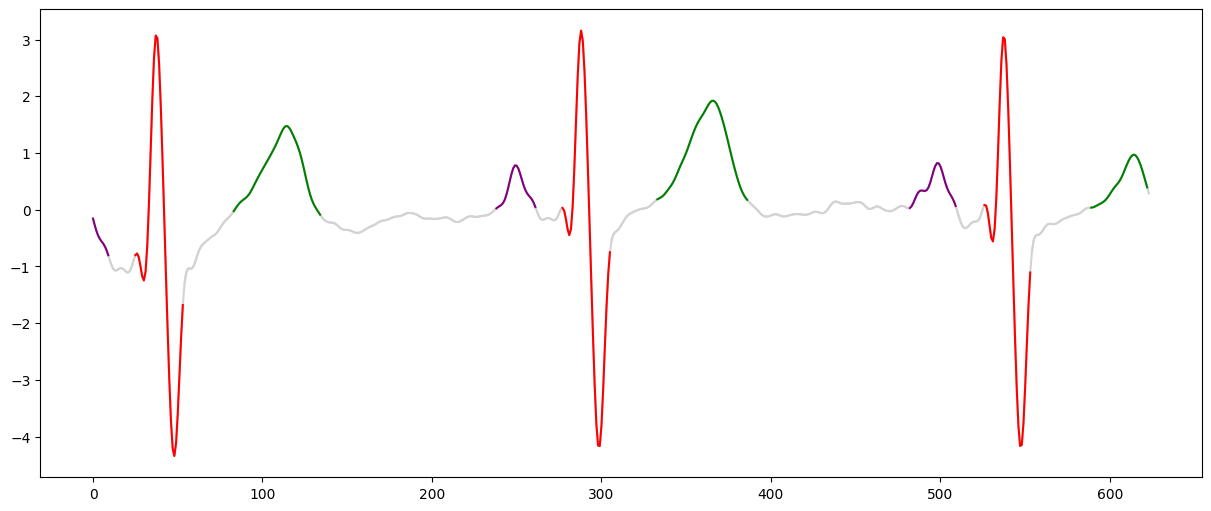

In [12]:
%matplotlib inline
import time
from IPython import display

with tf.device('/CPU:0'):
    model = tf.keras.models.load_model("../results/segmentation/model.tf")

    test_ds = ds_qtdb.load_test_dataset(
        test_patients=0.05,
        test_pt_samples=5,
        repeat=False,
        preprocess=preprocess
    )

    fig, ax = plt.subplots(figsize=(12, 5), layout="constrained")
    for x, y in test_ds.as_numpy_iterator():
        y_pred = model.predict(x.reshape((1, 1, -1, 1))).squeeze()
        y_pred = np.argmax(y_pred, axis=1).squeeze()
        # y_true = np.argmax(y.squeeze(), axis=1).squeeze()

        plot_segmentations(data=x.squeeze(), labels=None, preds=y_pred, fig=fig, ax=ax)
        display.clear_output(wait=True)
        display.display(fig)    
        time.sleep(2.0)  
        # input("Press Enter to continue...")
        ax.cla()
    plt.close(fig)
